In [1]:
import pandas as pd # manipulating data
import numpy as np # numerical operations
import seaborn as sns # good graphics plotting
from matplotlib import pyplot as plt # basic plotting
from sklearn.preprocessing import StandardScaler # scaling
from sklearn.linear_model import LogisticRegression # basic classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # advanced classifier
from sklearn.model_selection import train_test_split # data splitting for training
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, auc # metrics
from sklearn.svm import SVC # advanced classifier
from imblearn.over_sampling import SMOTE # oversampling
from scipy.stats import norm # normalization

from utils import * # confusion matrix plotting

## Descriptive analysis of the dataset

In [2]:
# Importing the data
data = pd.read_csv('final.csv')

In [3]:
data.head(5)

,Default,checkingstatus1,duration,history,purpose,amount,savings,employ,installment,status,...,residence,property,age,otherplans,housing,cards,job,liable,tele,foreign
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A46,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A42,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201


In [4]:
data.describe()

,Default,duration,amount,installment,residence,age,cards,liable
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


### Quick Description

Here we can see the description of each numerical column. Default is not evenly balanced with 30% of ones.

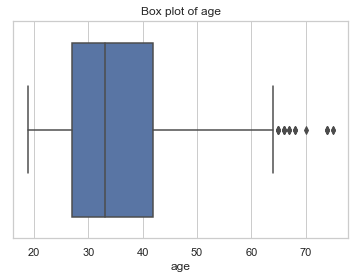

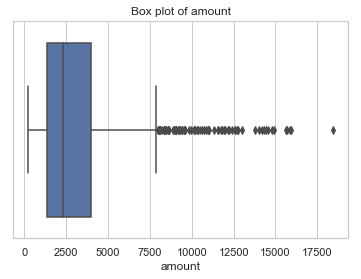

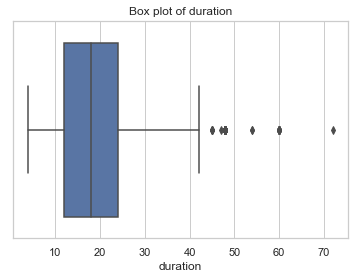

In [5]:
sns.set(style="whitegrid")

def boxplot(col):
    ax = sns.boxplot(x=data[col])
    plt.title('Box plot of {}'.format(col))
    plt.show()

boxplot("age")
boxplot("amount")
boxplot("duration")

### Boxplot intrepretation
We can see that we don't have a huge amount of outliers in our dataset however it should be usefull to check for the distribution of our numerical series.

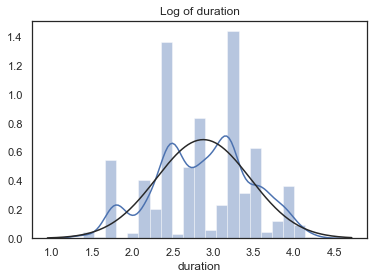

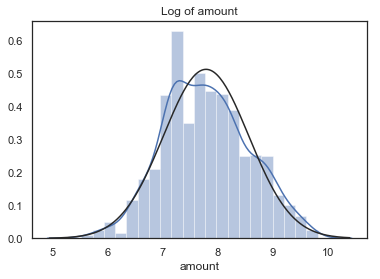

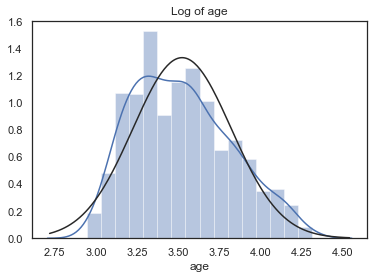

In [6]:
"""
In this Cell we prepare our data prep.
We check which column should be dummyfied.
Finally we plot the numerical series already
in the dataset and check whether they are normally
distributed or not.
"""

# get col names
numerical = list(data.describe().columns)
# create empty list
to_be_removed = []

# if a variable has more than 5 unique
# items we keep it, otherwise we ditch it
for num in numerical:
    if len(data[num].unique()) <= 5:
        to_be_removed.append(num)

for col in to_be_removed:
    numerical.remove(col)

del to_be_removed

sns.set_style(style='white')

# defining norm plot function
def norm_plot(series, title):
    sns.distplot(np.log(series), fit=norm)
    plt.title("Log of {}".format(title))
    plt.show()

# using our function on our numerical series
for col in numerical:
    series = data[col]
    norm_plot(series, col)

## Log normal interpretation
The graphs we can see show us that our data is to scarce to correctly identify it as mathematicaly normal. However given more data and the Law of Large Numbers (LLN) we should find normally distributed data.

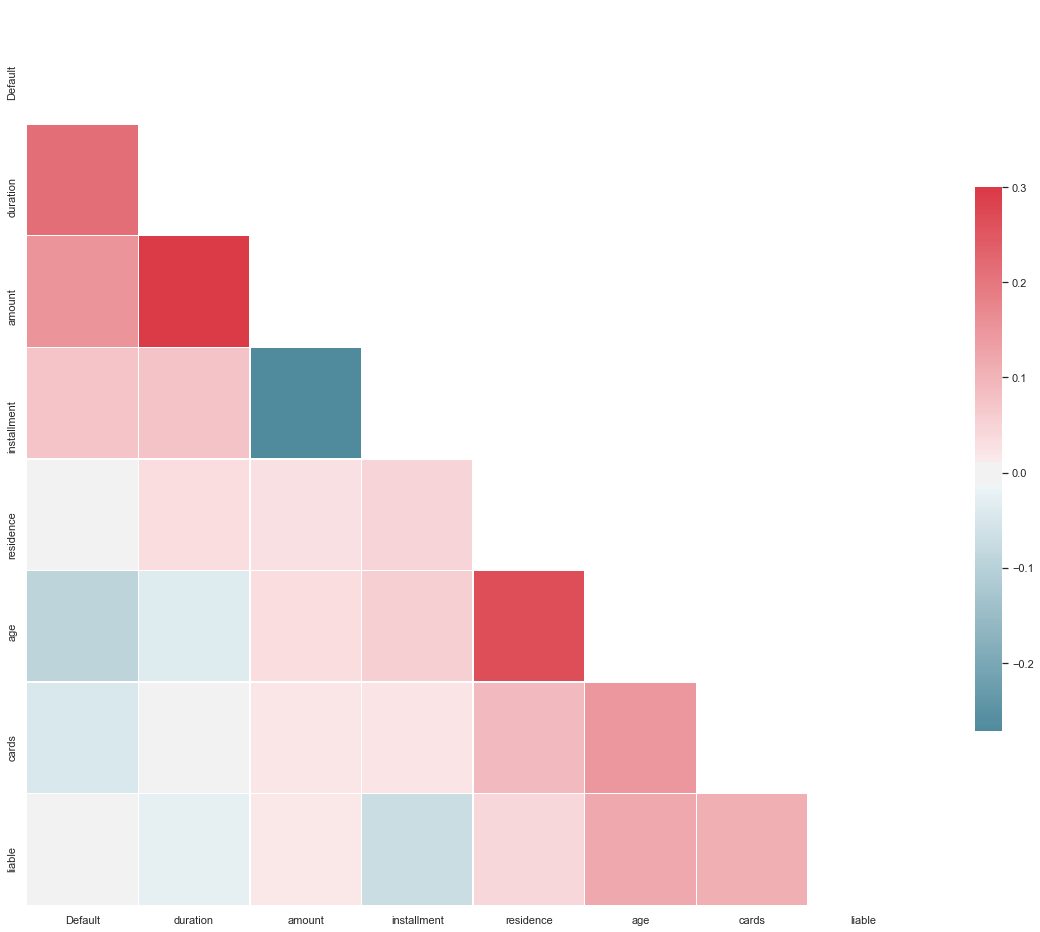

In [7]:
# define correlation matrix plotting
def plot_corr(data, size='small'):
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    if size =='big':
        f, ax = plt.subplots(figsize=(20, 20))
    else:
        f, ax = plt.subplots(figsize=(3, 3))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


plot_corr(data, 'big')
plt.show()

## Correlation Matrix interpretation
This correlation matrix allows us to see that numerical variables are in absolute average poorly correlated. However some correlations appear including age with residence and duration with amount. This gives us key information for what is coming. With domain knowledge we can easily infer that older borrowers do own their property and the longer time one borrows the riskier. Eventually we can see that default has some correlation with installment, duration and amount.

## Data preprocessing

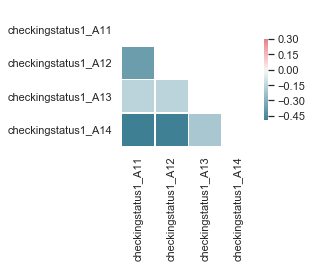

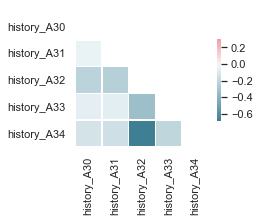

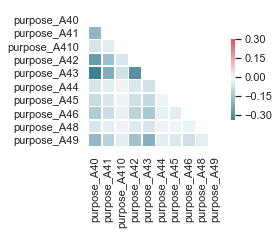

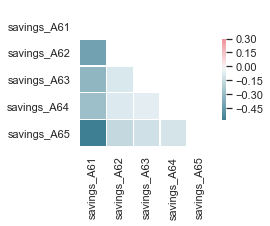

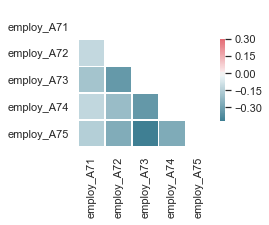

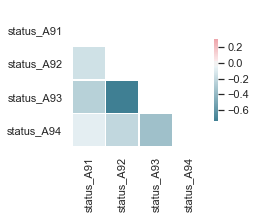

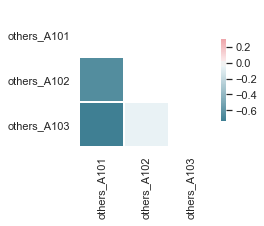

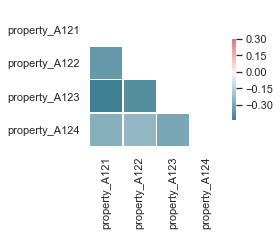

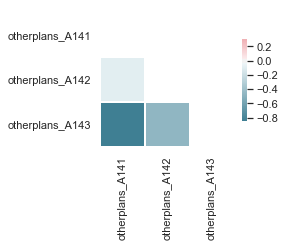

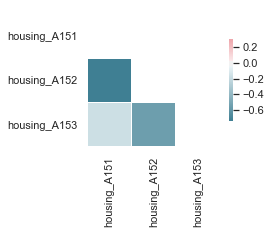

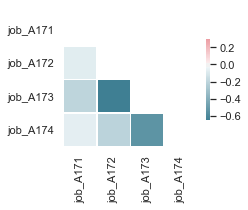

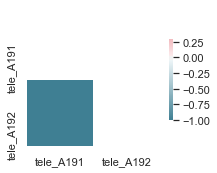

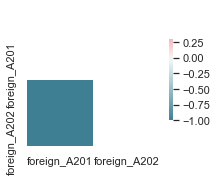

In [8]:
# If data is not numeric than convert it to dummy variables
for col in data.columns:
    if type(data[col][0]) is str:
        dummy = pd.get_dummies(data[col], prefix=col)
        plot_corr(dummy)
        data.drop(col, inplace=True, axis=1)
        data = pd.concat([data, dummy], axis=1)
    else:
        continue

As we can see, dummy variables are higly correlated to each other. This could surely cause problems when doing large scale machine learning but we only have 1000 rows and the models we will be doing will not go in production environments so we may as well just keep all of them.

In [9]:
data.head()

,Default,duration,amount,installment,residence,age,cards,liable,checkingstatus1_A11,checkingstatus1_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,tele_A191,tele_A192,foreign_A201,foreign_A202
0,0,6,1169,4,4,67,2,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,1,48,5951,2,2,22,1,1,0,1,...,1,0,0,0,1,0,1,0,1,0
2,0,12,2096,2,3,49,1,2,0,0,...,1,0,0,1,0,0,1,0,1,0
3,0,42,7882,2,4,45,1,2,1,0,...,0,1,0,0,1,0,1,0,1,0
4,1,24,4870,3,4,53,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [10]:
# separate "default" from dataset to normalise inputs
Default = data.Default
data.drop("Default", axis=1, inplace=True)
# normalizing inputs
data = (data - data.mean()) / (data.max() - data.min())
# adding back "default" to the dataset
data = pd.concat([Default,data], axis=1)
# deleting default to free memory
del Default

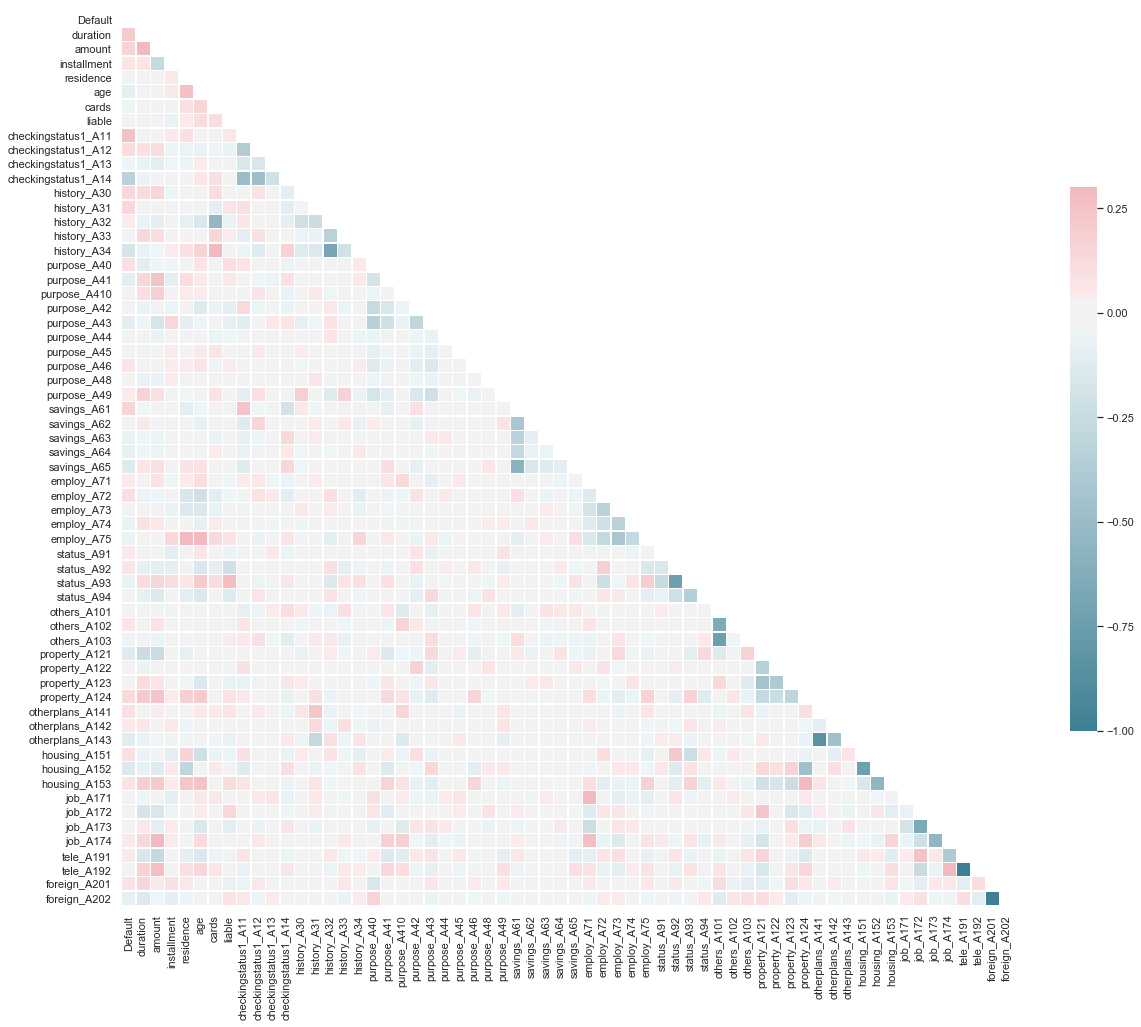

In [11]:
# plotting the normalized data correlation
plot_corr(data, "big")

## Splitting the data set

In [12]:
x = data.drop('Default', axis=1)
y = data.Default

x_train, x_test, y_train, y_test = train_test_split(x,y)

class_names = [0,1]

## Model fitting and ploting

In [13]:
"""
Fit the model
Predict test data
Plot confusion matrix
Compute recall and roc score
"""
def fit_plot(model):
    model.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    plot_confusion_matrix(np.array(y_test), y_pred, classes=class_names,
                          title='Confusion matrix')
    plt.show()

    recall = recall_score(np.array(y_test), y_pred)
    roc = roc_auc_score(np.array(y_test), y_pred)

    print('The recall for this model is: {}'.format(recall))
    print('The roc score for this model is: {}'.format(roc))

## Fitting a logit model

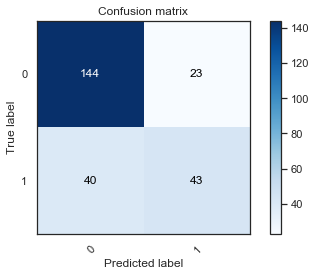

The recall for this model is: 0.5180722891566265
The roc score for this model is: 0.6901738691292114


In [14]:
reg = LogisticRegression(solver="lbfgs")
fit_plot(reg)

## Fitting a RandomForest model

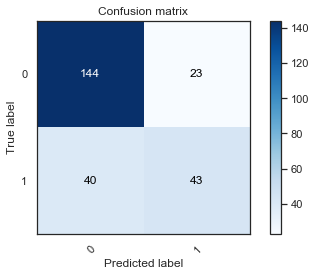

The recall for this model is: 0.5180722891566265
The roc score for this model is: 0.6901738691292114


In [15]:
forest = RandomForestClassifier(n_estimators=100, max_depth=50)
fit_plot(forest)

## Fitting an SVM model

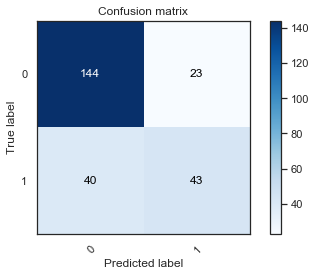

The recall for this model is: 0.5180722891566265
The roc score for this model is: 0.6901738691292114


In [16]:
svm = SVC(gamma='scale', probability=True)
fit_plot(svm)

## Fitting an Gradient Boosting model

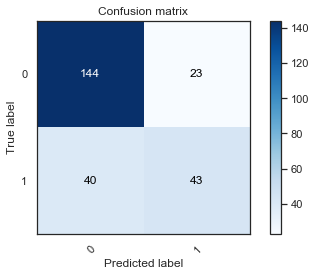

The recall for this model is: 0.5180722891566265
The roc score for this model is: 0.6901738691292114


In [17]:
gb = GradientBoostingClassifier()
fit_plot(gb)

## Plotting ROC Curves

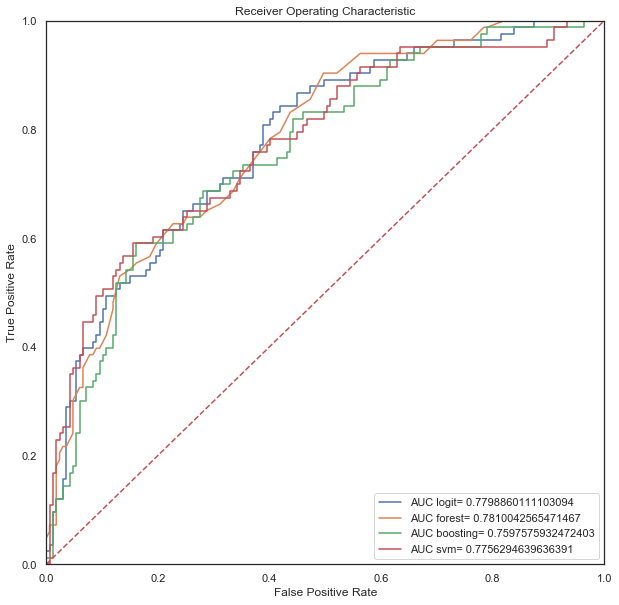

In [18]:
models = {'logit':reg,
          'forest':forest,
          'boosting':gb,
          'svm':svm}


plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
for name, model in models.items():
    probs = model.predict_proba(x_test)
    y_preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC {}= {}'.format(name,roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Models and Analysis
We fitted 4 models each of a special kind. All of these models performed in similar ways. We obtain very similar results with all of them. However we wish to predict wheter the future will Default or not and this is why we want to choose the final model using the recall metric. Let's use SMOTE to see if we get better results.

## Lets balance the dataset

In [19]:
x_smote, y_smote = SMOTE().fit_resample(x,y)

x_train, _ , y_train, _ = train_test_split(x_smote, y_smote)

## Fitting a logit model

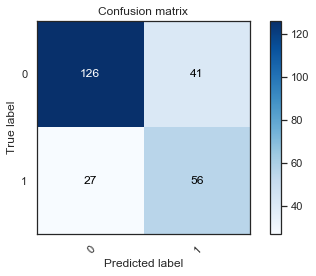

The recall for this model is: 0.6746987951807228
The roc score for this model is: 0.7145949065723973


In [20]:
reg = LogisticRegression(solver="lbfgs")
fit_plot(reg)

## Fitting a RandomForest model

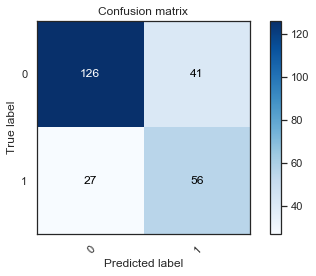

The recall for this model is: 0.6746987951807228
The roc score for this model is: 0.7145949065723973


In [21]:
forest = RandomForestClassifier(n_estimators=100, max_depth=50)
fit_plot(forest)

## Fitting an SVM model

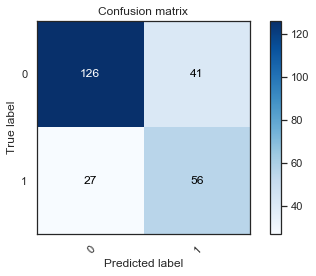

The recall for this model is: 0.6746987951807228
The roc score for this model is: 0.7145949065723973


In [22]:
svm = SVC(gamma='scale', probability=True)
fit_plot(svm)

## Fitting a GradientBoosting model

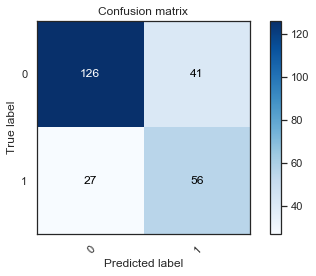

The recall for this model is: 0.6746987951807228
The roc score for this model is: 0.7145949065723973


In [23]:
gb = GradientBoostingClassifier()
fit_plot(gb)

## Plotting ROC Curves

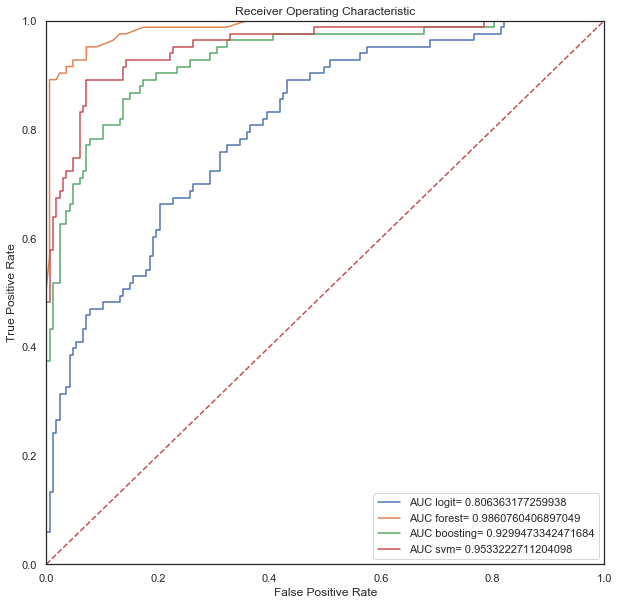

In [24]:
"""
Group models in a mapping
Plot each of their ROC
"""
models = {'logit':reg,
          'forest':forest,
          'boosting':gb,
          'svm':svm}


plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
for name, model in models.items():
    probs = model.predict_proba(x_test)
    y_preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC {}= {}'.format(name,roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### ROC Analysis
Earlier we plotted our ROC Curves and received results that were way less interesting. The impact of oversampling the dataset is very important. Here we can see that our Random Forest model has the best AUC along with the SVM model. However what really matters here is recall since we want to identify correctly which borrowers are going to Default. It is way more important than knowing which one will not. To this end we can simply plot the recall score and choose our best scoring model.

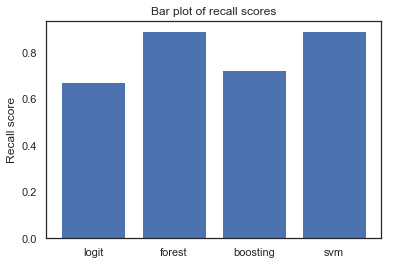

In [25]:
recalls = {}
for key, val in models.items():
    recalls[key] = recall_score(np.array(y_test), val.predict(x_test))
    
plt.title("Bar plot of recall scores")
plt.ylabel("Recall score")
plt.bar(recalls.keys(), recalls.values())
plt.show()

We can see that the best recall is achieved by the random forest model which we should use when predicting whether or not we should lend to a borrower.

### Analyzing models

It is crucial being able to explain to a borrower why his applications was refused and not just throw a refusal at his face. In order to do this let's check some models that can be easily interpretable.

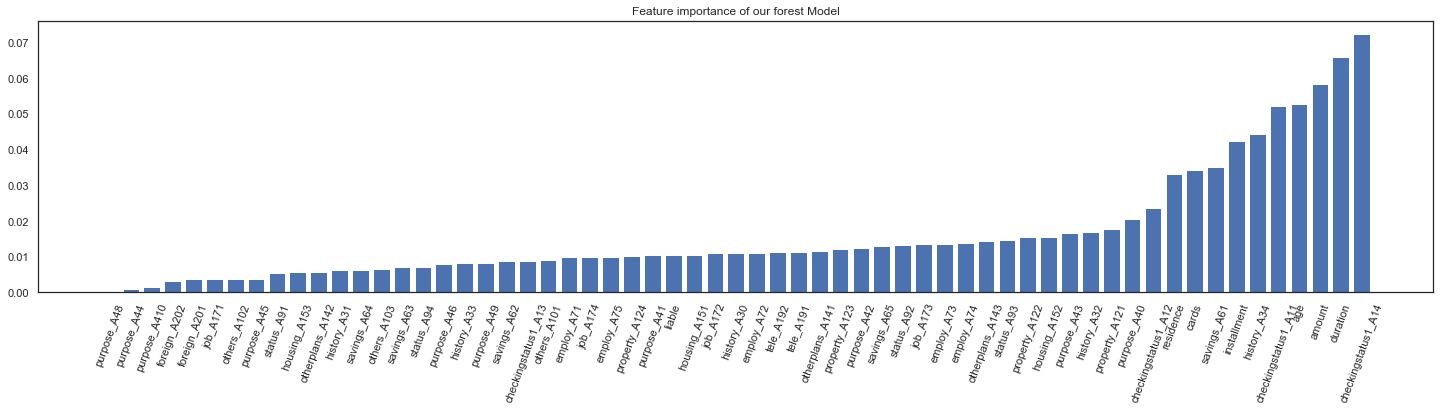

In [26]:
import operator
import collections

def prep_plot_importance(model_name, model_importance):    
    importance = {}
    for name, feat in zip(x.columns, model_importance):
        importance[name] = feat

    importance = sorted(importance.items(), key=operator.itemgetter(1))
    importance = collections.OrderedDict(importance)

    plt.figure(figsize=(25, 5))
    plt.title('Feature importance of our {} Model'.format(model_name))
    plt.bar(importance.keys(), importance.values())
    plt.xticks(rotation=70)
    plt.show()

prep_plot_importance("forest",forest.feature_importances_)

#### Feature importance
Feature importance is a key insight we can take from our random forsest model. It gives us an indication of which features are to be focused on and studied.
Here we can see that the amount, duration, age and not having a checking account matter a lot to our model.
However unexcpetidly the liability grade matters very little to our model. Also lots of dummy variables are of very little use one can easily expect that since they are higly correlated.

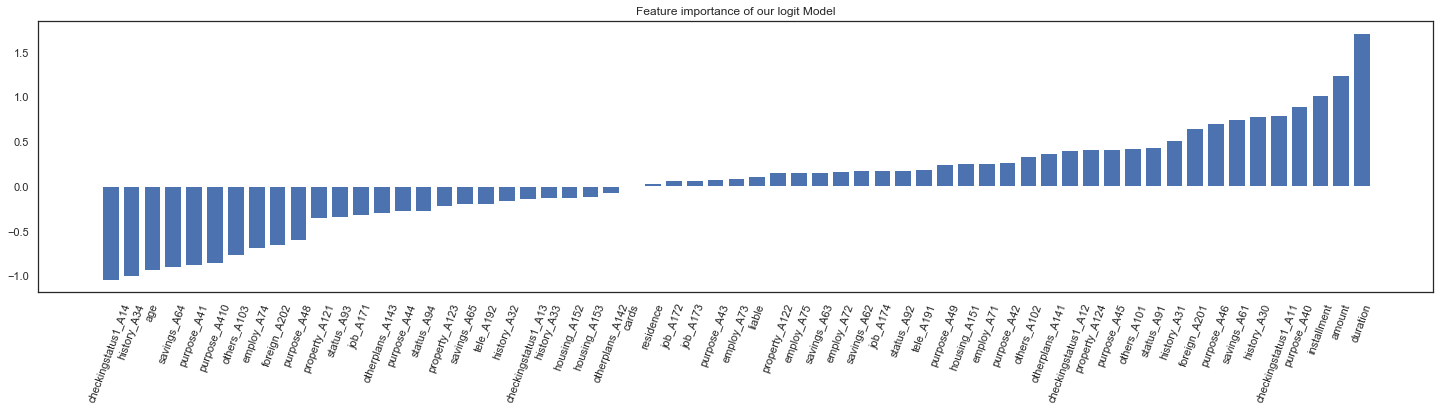

In [27]:
prep_plot_importance("logit",reg.coef_[0])

#### Logit coefficients
The coefficient of our logit model can be very handy to catch linear relationships between the independent variables and our "Default" variable. Another insight we get is the way the relationship has. For example duration is positively impacting the results thus augmenting the risks of default. Conversly not having a checking account of being older will impact negatively the risk of Default. As we saw it in the previous cell lots of dummy variables are of little to no use and the liability flag given by the credit offerer is not a all used by our linear model here.

### HyperParameter Optimization
In order to improve our model for further use we should be using feature selection and grid search for hyperparameter optimization and meaningfulnes. However we only have 1000 rows and feature selection here is difficult if we want to maintain good results.

In [28]:
FEATURE_SELECT = False
MAX_FEATURES = 20
if FEATURE_SELECT:
    # Selected most important features from random forest model
    from sklearn.feature_selection import SelectFromModel

    # Select most important features of orginal forest model
    x_selected = SelectFromModel(forest, threshold=-np.inf, max_features=MAX_FEATURES).fit_transform(x, y)

    x_train, x_test, y_train, y_test = train_test_split(x_selected, y)

In [29]:
# Perform optimization on parameters for an optimal random forest classifier
from sklearn.model_selection import RandomizedSearchCV

# define parameters to optimize
params = {
    'n_estimators':np.linspace(25, 500, 10, dtype=np.int),
    'max_depth': np.linspace(15, 200, 10, dtype=np.int),} 

random_forest = RandomForestClassifier()
clf = RandomizedSearchCV(random_forest, params, cv=5, verbose=1)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   21.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': array([ 25,  77, 130, 183, 236, 288, 341, 394, 447, 500]), 'max_depth': array([ 15,  35,  56,  76,  97, 117, 138, 158, 179, 200])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [30]:
random_forest = clf.best_estimator_

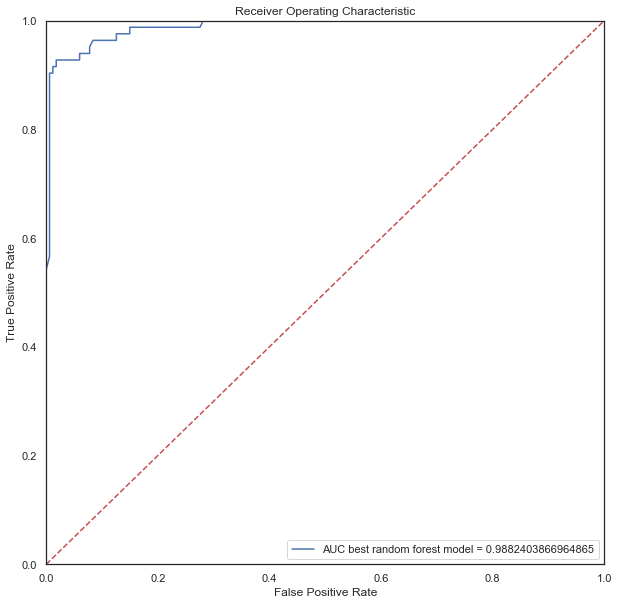

In [31]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
probs = random_forest.predict_proba(x_test)
y_preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC best random forest model = {}'.format(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

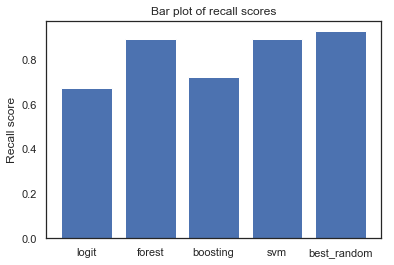

In [32]:
models['best_random'] = random_forest

recalls = {}
for key, val in models.items():
    recalls[key] = recall_score(np.array(y_test), val.predict(x_test))
    
plt.title("Bar plot of recall scores")
plt.ylabel("Recall score")
plt.bar(recalls.keys(), recalls.values())
plt.show()

#### Results
The difference between best_random and our original random forest is thin however the more we improve a model the harder is gets. In our case the amount of data too small to fit a more advanced model such as a neural network. We should still use the best random forest model we created for prediction if we were to use any of the models we created.

## Conclusion
We went through a typical data analysis analysing descriptive statistics, preprocessing data, normalizing it and modelling various classifiers. We then compared our models with the recall scores and the AUC. Finally, we optimized the best model we had so that we achieve the best results possible. We also tried removing variables according to our first random forest model in order to improve the model explainability and make it faster to run in a theoretical production environment. This decreased significantly our results so we decided to let users decide themselves if they want to inlcude this feature.